In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp


In [2]:
# For my computer: so it doesn't use shared GPU memory which is slower
mempool = cp.get_default_memory_pool()
mempool.set_limit(size=3.7*1024**3) # Allowing cupy 3.8 GB of GPU memory

## Model definition

In [3]:
olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
olfactory_data = np.array(olfactory_data)

In [4]:
# olfactory_data = pd.read_csv('./Data/statistics_nose_5e6.dat', sep=' ', skiprows=[0], header=None).values.T
# olfactory_data = np.array(olfactory_data[:320,:])

In [5]:
# Model size
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (35, 153)
State count: 5355


In [6]:
# goal state
olfactory_data[17,0]

0.9988461538461538

In [7]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [8]:
# states
state_grid = []

# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

observations = np.zeros((state_count, 4, 2))
observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
observations[:,:,1] = (1 - observations[:,:,0])

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [9]:
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

In [10]:
# Reward function
def reward_func(s,a,sn,o):
    # return np.where(sn == (175*env_shape[1]), 1.0, 0.0)
    return np.where(sn == (17*env_shape[1]), 1.0, 0.0)

In [11]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[10/14/2023, 00:33:47] Instantiation of MDP Model:
[10/14/2023, 00:33:47] - 5355 states
[10/14/2023, 00:33:47] - 4 actions
[10/14/2023, 00:33:47] - At most 1 reachable states per state-action pair
[10/14/2023, 00:33:47] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[10/14/2023, 00:33:47]     > Done in 0.000s
[10/14/2023, 00:33:47] - Generation of state grid
[10/14/2023, 00:33:47] - Generating start probabilities table
[10/14/2023, 00:33:47] - Starting computation of reachable state probabilities from transition data
[10/14/2023, 00:33:47]     > Done in 0.000s
[10/14/2023, 00:33:47] POMDP particular parameters:
[10/14/2023, 00:33:47] - 2 observations
[10/14/2023, 00:33:47] - Starting of transitional observations for reachable states table
[10/14/2023, 00:33:47]     > Done in 0.001s
[10/14/2023, 00:33:47] - Starting gener

## VI Solve

In [12]:
from src.mdp import VI_Solver

In [13]:
solver = VI_Solver(eps=1e-3)

In [14]:
solution, history = solver.solve(model, use_gpu=True)

[10/14/2023, 00:33:47] Sending Model to GPU...
[10/14/2023, 00:33:47]     > Done in 0.245s


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
print(history.summary)

Summary of Value Iteration run
  - Model: 5355-state, 4-action
  - Converged in 231 iterations and 0.3930 seconds
  - Took on average 0.0017s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


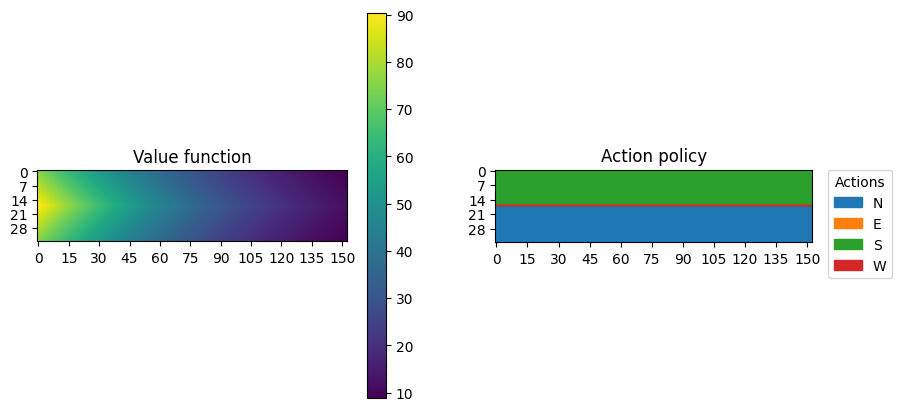

In [16]:
solution.plot()

## FSVI

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=100,
                                        horizon=300,
                                        mdp_policy=solution,
                                        belief_memory_depth=10,
                                        # prune_level=2,
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 45.5553s

  - Expand function took on average 0.2558s and yielded on average 75.79 beliefs per iteration.
  - Backup function took on average 0.1998s and yielded on average value functions of size 845.55 per iteration.


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


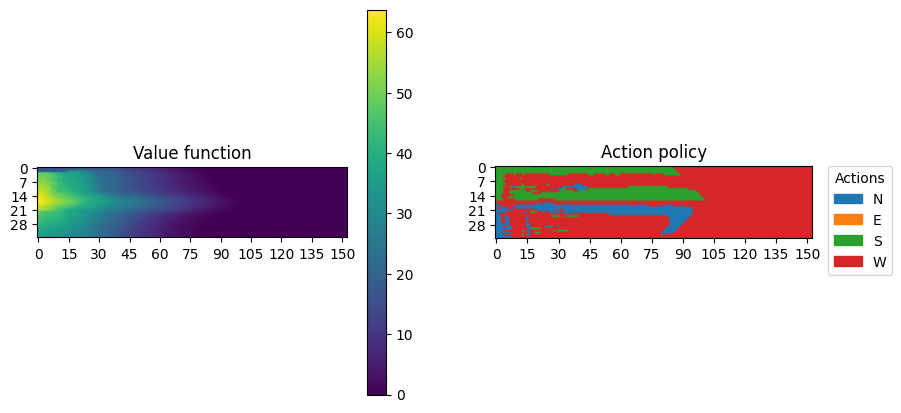

In [20]:
fsvi_solution.plot()

In [19]:
len(fsvi_solver._belief_memory)

1337

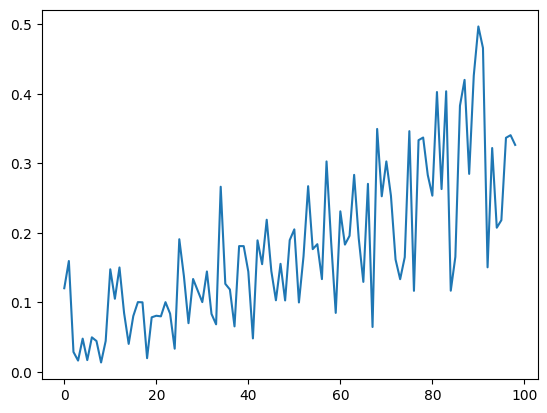

In [20]:
plt.plot(np.arange(len(hist.backup_times)-1), hist.backup_times[1:])

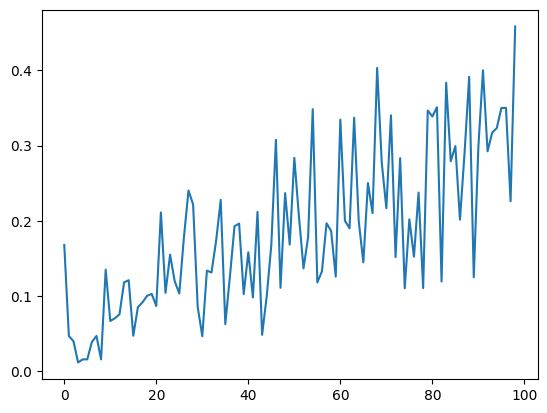

In [20]:
plt.plot(np.arange(len(hist.backup_times)-1), hist.backup_times[1:])

In [18]:
from cProfile import Profile
from pstats import SortKey, Stats

with Profile() as profile:
    fsvi_solver.solve(model=model,
                    expansions=100,
                    horizon=300,
                    mdp_policy=solution,
                    # expand_prune_level=2,
                    # history_tracking_level=2,
                    use_gpu=True)
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

         5801488 function calls (5789399 primitive calls) in 52.357 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1062770    0.215    0.000    0.215    0.000 pomdp.py:337(values)
   778070    0.211    0.000    0.286    0.000 {built-in method builtins.isinstance}
561605/561324    0.095    0.000    0.095    0.000 {built-in method builtins.len}
   540483    0.524    0.000    0.612    0.000 __init__.py:830(get_array_module)
   522493    0.396    0.000    0.580    0.000 pomdp.py:451(<genexpr>)
   522493    0.481    0.000    1.103    0.000 pomdp.py:456(<genexpr>)
   133088    0.223    0.000    0.402    0.000 numeric.py:1855(isscalar)
    71248    0.174    0.000    0.174    0.000 _internal.py:250(__init__)
    71248    0.050    0.000    0.050    0.000 _internal.py:304(data)
    71048    0.087    0.000    0.128    0.000 syncdetect.py:36(_declare_synchronize)
    71048    0.041    0.000    0.041    0.000 syncdetect.py:27(_is_allowe

In [24]:
%timeit solution.alpha_vector_array[0].tobytes()

75 µs ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
def t1():
    x = fsvi_solution.alpha_vector_array
    dtype = np.dtype('S{:d}'.format(x.shape[1] * x.dtype.itemsize))
    in_bytes = np.frombuffer(x.tobytes(), dtype=dtype)
    t = {bi: i for bi, i in zip(in_bytes, np.arange(x.shape[0]))}

In [20]:
%timeit t1()

205 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def t2():
    t = {alpha_vector.values.tobytes(): i for alpha_vector, i in zip(fsvi_solution.alpha_vector_list, np.arange(len(fsvi_solution)))}
    a = [fsvi_solution.alpha_vector_list[i] for i in t.values()]

In [24]:
%timeit t2()

298 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 63.4330s

  - Expand function took on average 0.2504s and yielded on average 80.46 beliefs per iteration.
  - Backup function took on average 0.3839s and yielded on average value functions of size 1025.29 per iteration.


In [19]:
len(fsvi_solution)

1015

In [ ]:
fsvi_solution._uniqueness_dict.u

In [37]:
vect_array = fsvi_solution.alpha_vector_array

indices = []

for i, v in enumerate(vect_array):
    is_dom_by = cp.all(vect_array >= v, axis=1)
    if len(cp.where(is_dom_by)[0]) == 1:
        indices.append(i)

In [39]:
fsvi_solution.alpha_vector_array[indices].shape

(916, 5355)

In [19]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 68.1278s

  - Expand function took on average 0.2703s and yielded on average 82.34 beliefs per iteration.
  - Backup function took on average 0.4109s and yielded on average value functions of size 1164.13 per iteration.


In [109]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 66.3804s

  - Expand function took on average 0.2960s and yielded on average 87.36 beliefs per iteration.
  - Backup function took on average 0.3678s and yielded on average value functions of size 887.19 per iteration.


pruning exploration

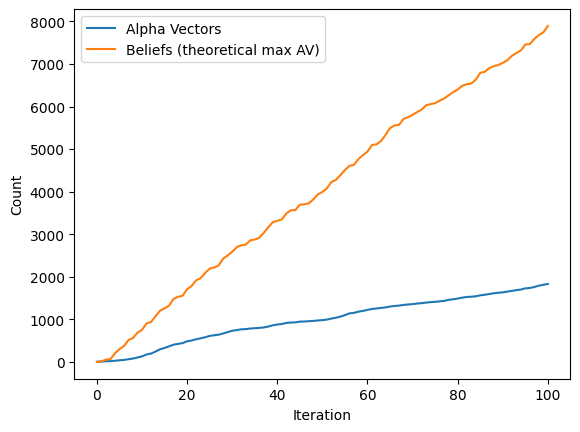

In [32]:
plt.plot(np.arange(len(hist.alpha_vector_counts)), hist.alpha_vector_counts, label='Alpha Vectors')
plt.plot(np.arange(len(hist.alpha_vector_counts)), np.cumsum(hist.beliefs_counts), label='Beliefs (theoretical max AV)')
plt.xlabel('Iteration')
plt.ylabel('Count')
plt.legend()

Back time improvement

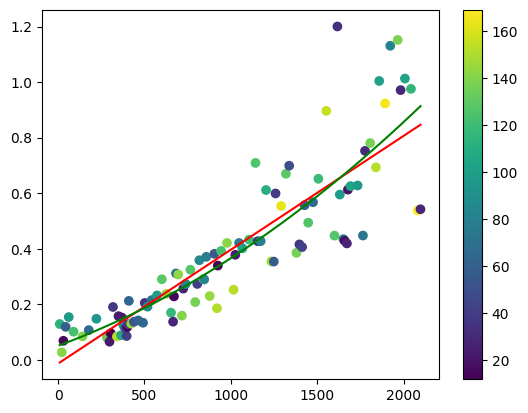

In [21]:
# Backup runtime per alpha vector count
x = np.array(hist.alpha_vector_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.beliefs_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, c='red')

fit = np.poly1d(np.polyfit(x, y, 2))
plt.plot(x, fit(x), c='green')

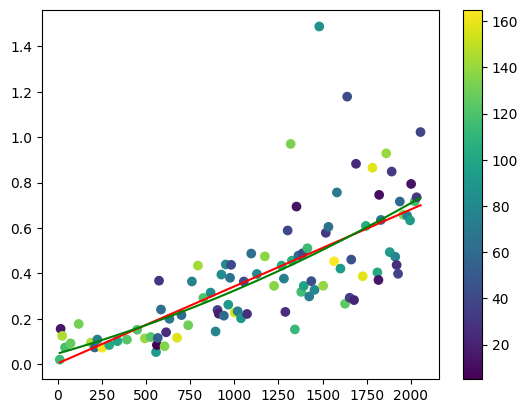

In [21]:
# With improved 3rd step

# Backup runtime per alpha vector count
x = np.array(hist.alpha_vector_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.beliefs_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, c='red')

fit = np.poly1d(np.polyfit(x, y, 2))
plt.plot(x, fit(x), c='green')

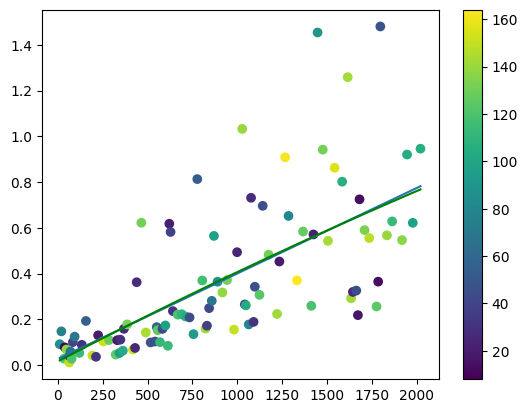

In [34]:
# Backup runtime per alpha vector count
x = np.array(hist.alpha_vector_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.beliefs_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1, c='red')
plt.plot(x, a*x+b)

fit = np.poly1d(np.polyfit(x, y, 2))
plt.plot(x, fit(x), c='green')

In [20]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 97.6274s

  - Expand function took on average 0.5387s and yielded on average 80.39 beliefs per iteration.
  - Backup function took on average 0.4375s and yielded on average value functions of size 964.96 per iteration.


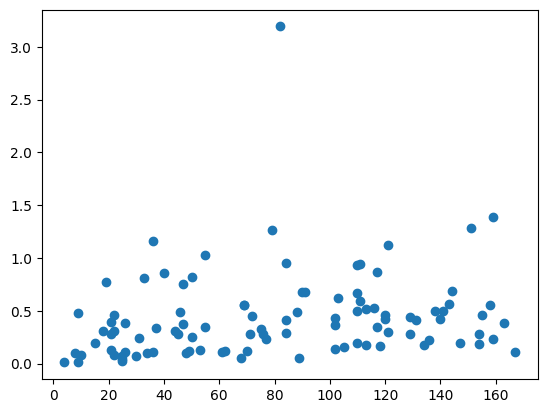

In [21]:
plt.scatter(hist.beliefs_counts[1:], hist.backup_times)

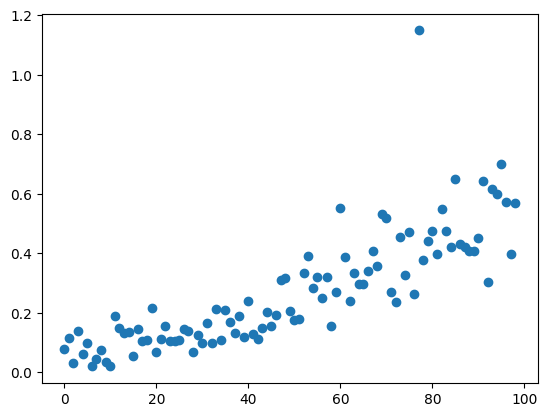

In [26]:
plt.scatter(np.arange(len(hist.backup_times[1:])), hist.backup_times[1:])

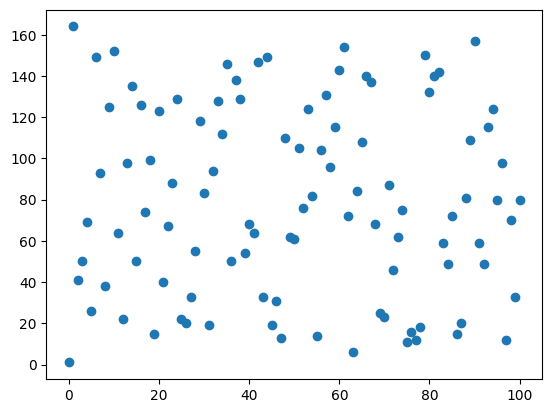

In [25]:
plt.scatter(np.arange(len(hist.beliefs_counts)), hist.beliefs_counts, )

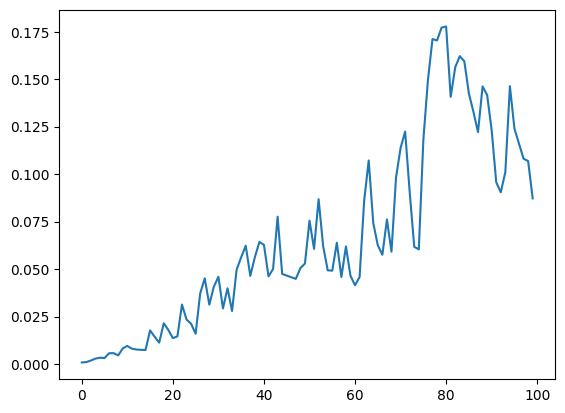

In [28]:
plt.plot(np.arange(len(hist.value_function_changes)), hist.value_function_changes)

## FSVI with mdp solution as initial value function

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model, 100, 300, mdp_policy=solution, initial_value_function=solution, use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

Converged early...


## Simulation

In [21]:
a = Agent(model)
a.value_function = fsvi_solution.to_cpu()

In [22]:
sim_hist = a.simulate(start_state=(153*13)-1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 1.31234
	- Steps: 178
	- Total rewards: 1.0
	- End state: s_17_0


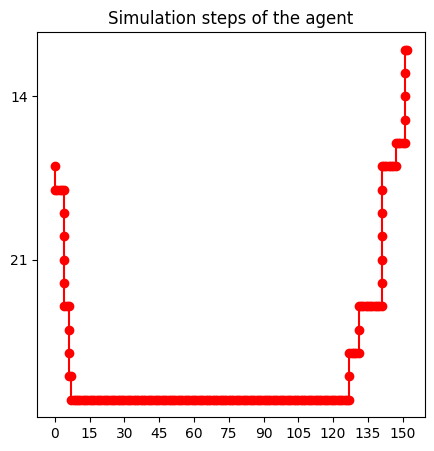

In [23]:
sim_hist.plot_simulation_steps()

In [24]:
sim_hist.save_simulation_video()

Video saved at 'Sim Videos/s5355-a4-20231014_003610.mp4'...


In [33]:
sim_hist.actions[19]

3

In [32]:
sim_hist.observations[19]

1

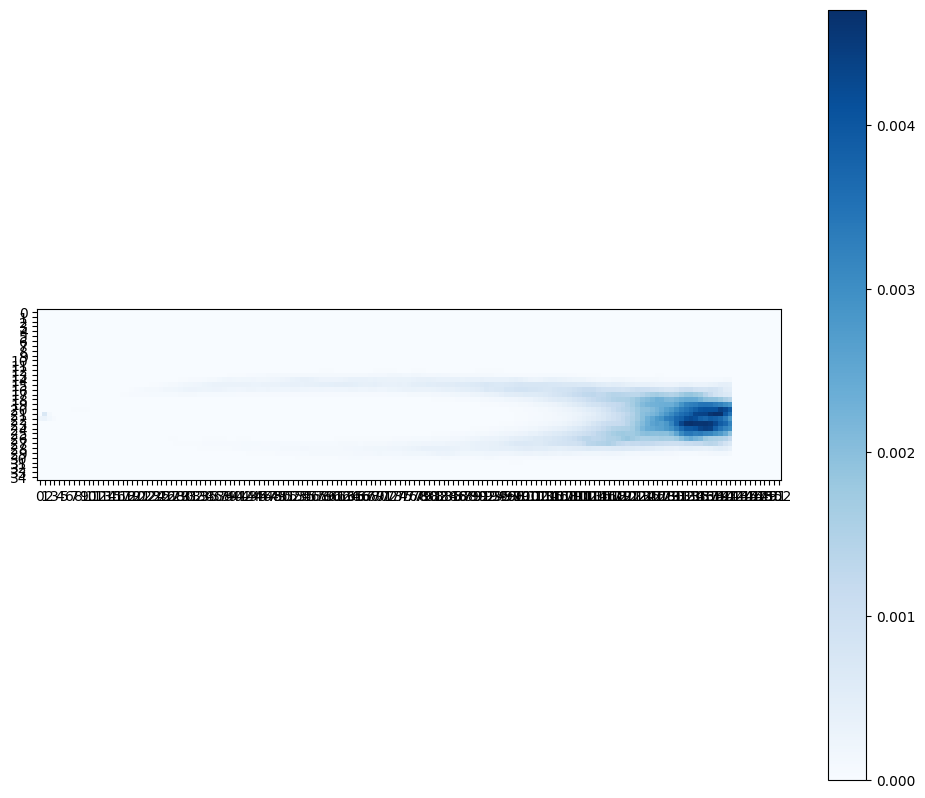

In [31]:
sim_hist.beliefs[19].plot(size=10)

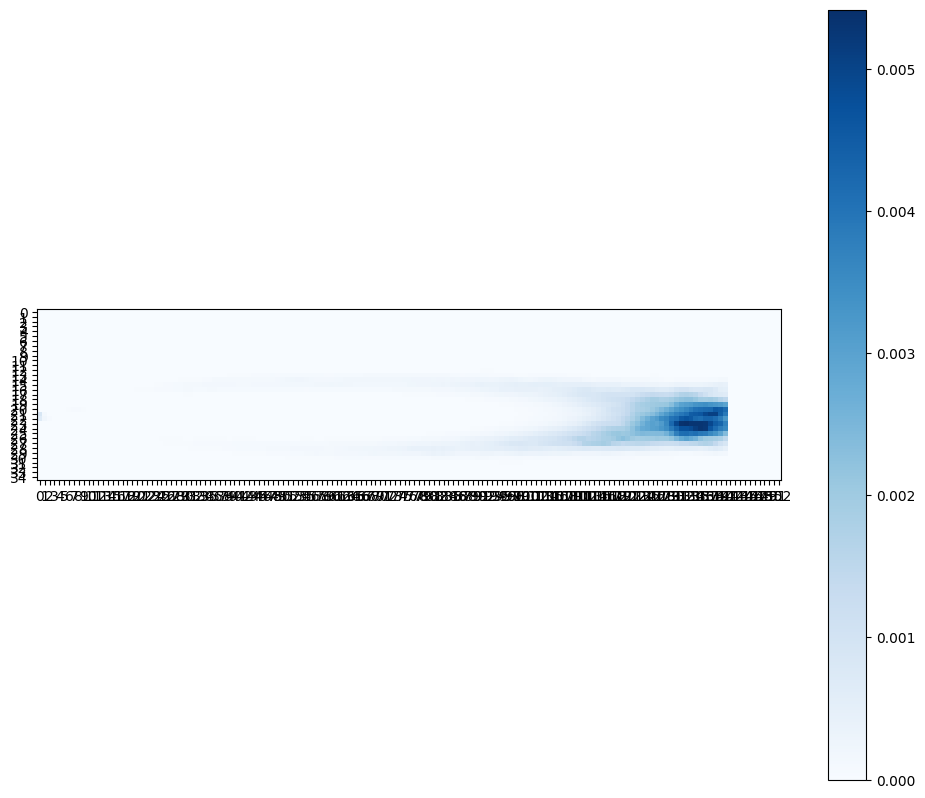

In [30]:
sim_hist.beliefs[20].plot(size=10)

In [21]:
sim_hist.save_simulation_video(fps=10)

Video saved at 'Sim Videos/s5355-a4-20231009_014051.mp4'...
